# Crime and Parks

For our final project we wanted to know whether areas with more parks had less crime than areas with fewer or no parks.

In order to investigate this question we decided to look at crime and park data from 5 major cities: New York City, Chicago, Philadelphia, Boston, and San Francisco. Because we are looking at a geographic connection, we decided to look at only one year at a time. We initially looked only at the year 2016.

For data we will use:

* Park or "Open Space" data or shapefiles from:
  * New York City: https://data.cityofnewyork.us/Recreation/Open-Space-Parks-/g84h-jbjm
  * Chicago: https://dev.socrata.com/foundry/data.cityofchicago.org/ejsh-fztr
  * Philadelphia: https://www.opendataphilly.org/dataset/parks-and-recreation-assets
  * Boston: https://data.boston.gov/dataset/open-space
  * San Francisco: https://data.sfgov.org/Culture-and-Recreation/Park-and-Open-Space-Map/4udc-s3pr


* Common geographical areas from:
  * New York City: https://dev.socrata.com/foundry/data.cityofnewyork.us/kmub-vria
  * Chicago: https://dev.socrata.com/foundry/data.cityofchicago.org/igwz-8jzy
  

* Crime APIs and data from:
  * New York City: https://dev.socrata.com/foundry/data.cityofnewyork.us/9s4h-37hy
  * Chicago: https://dev.socrata.com/foundry/data.cityofchicago.org/6zsd-86xi
  * Philadelphia: https://cityofphiladelphia.github.io/carto-api-explorer/#incidents_part1_part2
  * Boston: https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system
  * San Francisco: https://dev.socrata.com/foundry/data.sfgov.org/cuks-n6tp

Boston does not have an API interface, so we will instead download the csv directly. Luckily Boston switched from an old system to a new system, so the csv file we are interested in only has data from August 2015 to present, which will make it less arduous to download and work with.

In [193]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import shape


import requests, json

import pandas as pd
import seaborn as sns
sns.set_style({"axes.grid": "False"}, {'axes.axisbelow': "False"})
sns.set_style({"axes.linewidth": 0})

import pytz
import datetime

from urllib.parse import quote

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.mixed_linear_model as sm_mlm

from time import sleep

### Chicago

We will acquire the data for crime in Chicago similarly to how we did in class for the Weather and Crime example.

In [240]:
soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
soql += quote("SELECT id, community_area, primary_type ")
soql += quote("WHERE year == 2016 ")
soql += quote("LIMIT 300000")

resp = requests.get(soql).json()
chicago_crime = pd.DataFrame(resp)
chi_CA_count = chicago_crime.groupby("community_area").count()

In [223]:
soql = "https://data.cityofchicago.org/resource/igwz-8jzy.json?$query="
soql += quote("SELECT area_numbe as Number, community, the_geom ")
soql += quote("LIMIT 300000")

resp = requests.get(soql).json()

Because the data is downloaded as a json object, and thus parsed as a dictionary, we must convert it into geopandas data frame. 

In [224]:
data = resp
for d in data:
    d['the_geom'] = shape(d['the_geom'])

chicago_comm_areas = gpd.GeoDataFrame(data).set_geometry('the_geom')
chicago_comm_areas.head()

,Number,community,the_geom
0,35,DOUGLAS,(POLYGON ((-87.60914087617894 41.8446925026539...
1,36,OAKLAND,(POLYGON ((-87.59215283879394 41.8169293462668...
2,37,FULLER PARK,(POLYGON ((-87.62879823733725 41.8018930336891...
3,38,GRAND BOULEVARD,(POLYGON ((-87.6067081256125 41.81681377057218...
4,39,KENWOOD,(POLYGON ((-87.59215283879394 41.8169293462668...


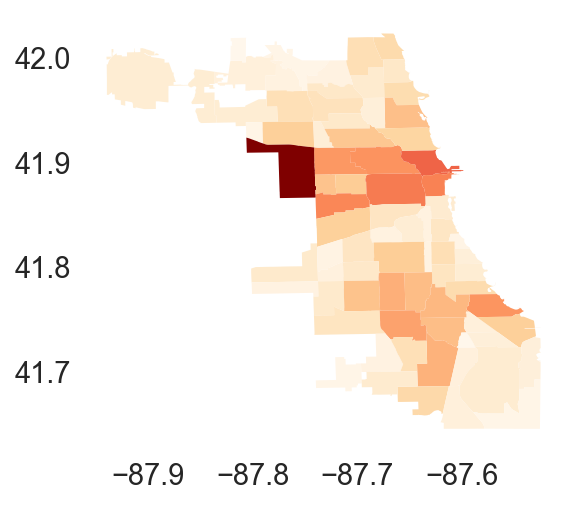

In [262]:
chi_CA_count = chi_CA_count.reset_index()
chicago_comm_areas = chicago_comm_areas.merge(chi_CA_count, left_on = 'Number', right_on = 'community_area')
CAMap = chicago_comm_areas.plot(column = 'id', cmap = 'OrRd', legend=True)
CAMap.set_title("Crimes per community area")
CAMap.yaxis.set_visible(False)
CAMap.xaxis.set_visible(False)

In [226]:
chi_CA_count.set_index('community_area', inplace = True)

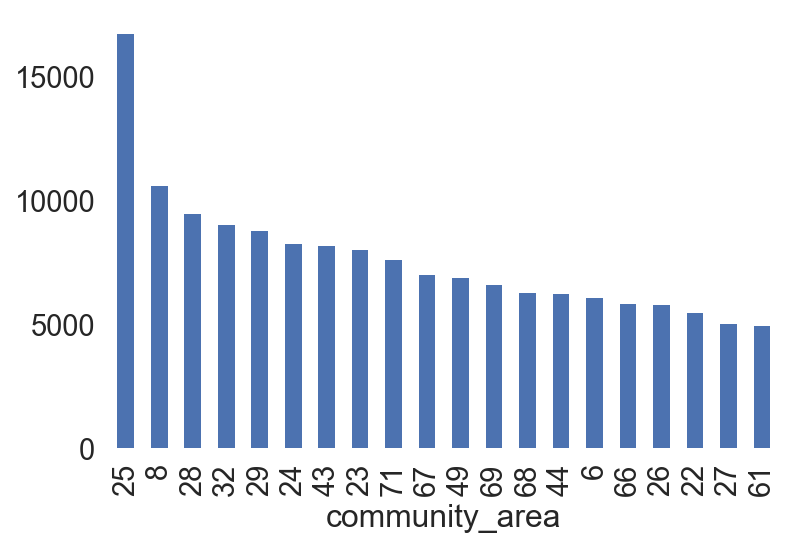

In [204]:
chi_CA_count.sort_values('id', ascending = False)['id'].head(20).plot.bar()

So community area 25 is by far the highest total amount of crime in 2016.

In [247]:
CAPop = pd.read_csv("CAPop.csv", dtype={'Community Area': str})

In [252]:
chicago_comm_areas = chicago_comm_areas.merge(CAPop, left_on = "community_area", right_on = "Community Area")

In [253]:
chicago_comm_areas.head()

,Number,community,the_geom,community_area,id,primary_type,Community Area,Population
0,35,DOUGLAS,(POLYGON ((-87.60914087617894 41.8446925026539...,35,2597,2597,35,18238
1,36,OAKLAND,(POLYGON ((-87.59215283879394 41.8169293462668...,36,698,698,36,5918
2,37,FULLER PARK,(POLYGON ((-87.62879823733725 41.8018930336891...,37,925,925,37,2876
3,38,GRAND BOULEVARD,(POLYGON ((-87.6067081256125 41.81681377057218...,38,3284,3284,38,21929
4,39,KENWOOD,(POLYGON ((-87.59215283879394 41.8169293462668...,39,1405,1405,39,17841


In [254]:
chicago_comm_areas['Crimes per person'] = chicago_comm_areas['id']/chicago_comm_areas['Population']

In [255]:
chicago_comm_areas.head()

,Number,community,the_geom,community_area,id,primary_type,Community Area,Population,Crimes per person
0,35,DOUGLAS,(POLYGON ((-87.60914087617894 41.8446925026539...,35,2597,2597,35,18238,0.142395
1,36,OAKLAND,(POLYGON ((-87.59215283879394 41.8169293462668...,36,698,698,36,5918,0.117945
2,37,FULLER PARK,(POLYGON ((-87.62879823733725 41.8018930336891...,37,925,925,37,2876,0.321627
3,38,GRAND BOULEVARD,(POLYGON ((-87.6067081256125 41.81681377057218...,38,3284,3284,38,21929,0.149756
4,39,KENWOOD,(POLYGON ((-87.59215283879394 41.8169293462668...,39,1405,1405,39,17841,0.078751


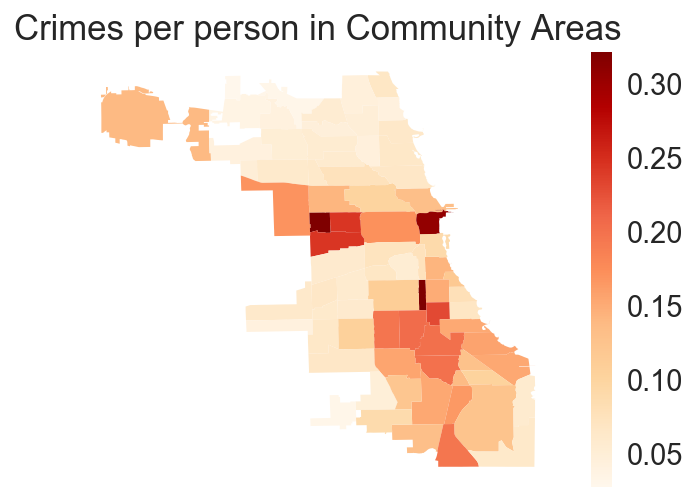

In [277]:
PerPerson = chicago_comm_areas.plot(column = 'Crimes per person', cmap = 'OrRd', legend=True)
PerPerson.set_title("Crimes per person in Community Areas")
PerPerson.yaxis.set_visible(False)
PerPerson.xaxis.set_visible(False)

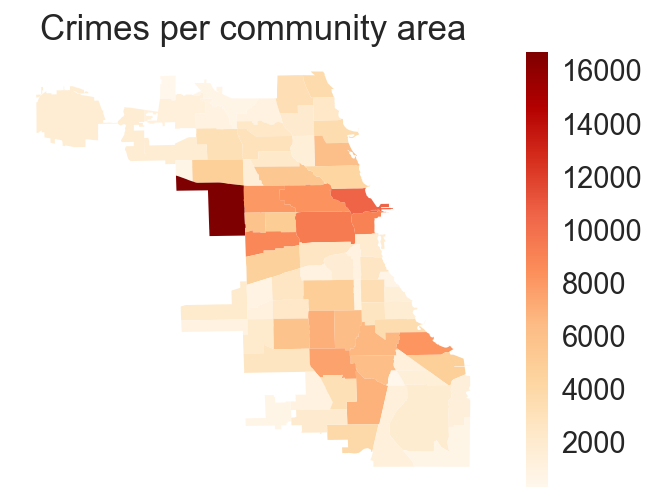

In [279]:
CAMap = chicago_comm_areas.plot(column = 'id', cmap = 'OrRd', legend=True)
CAMap.set_title("Crimes per community area")
CAMap.yaxis.set_visible(False)
CAMap.xaxis.set_visible(False)

The map looks slightly different now that we adjusted for population in the community areas.

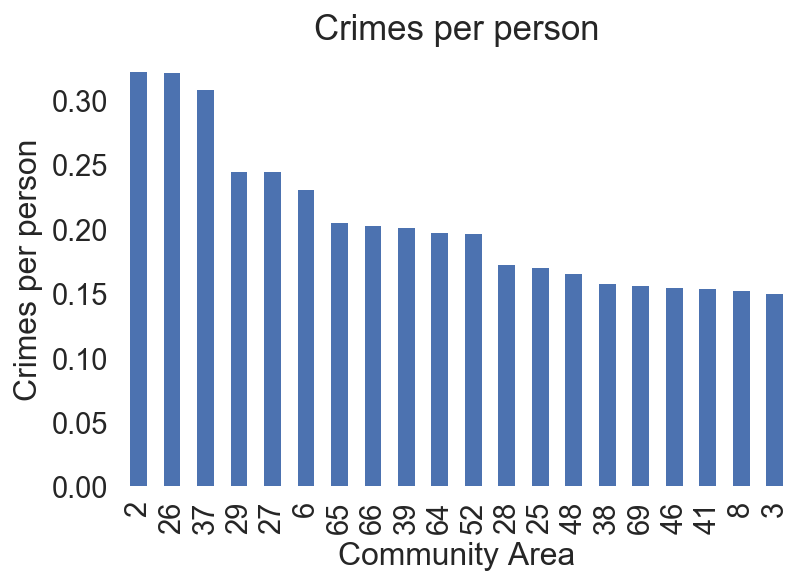

In [290]:
CPP = chicago_comm_areas[['Number','Crimes per person']].sort_values('Crimes per person', ascending = False).head(20).plot.bar()
CPP.set_title("Crimes per person")
CPP.set_xlabel("Community Area")
CPP.set_ylabel("Crimes per person")
CPP.legend_.remove()

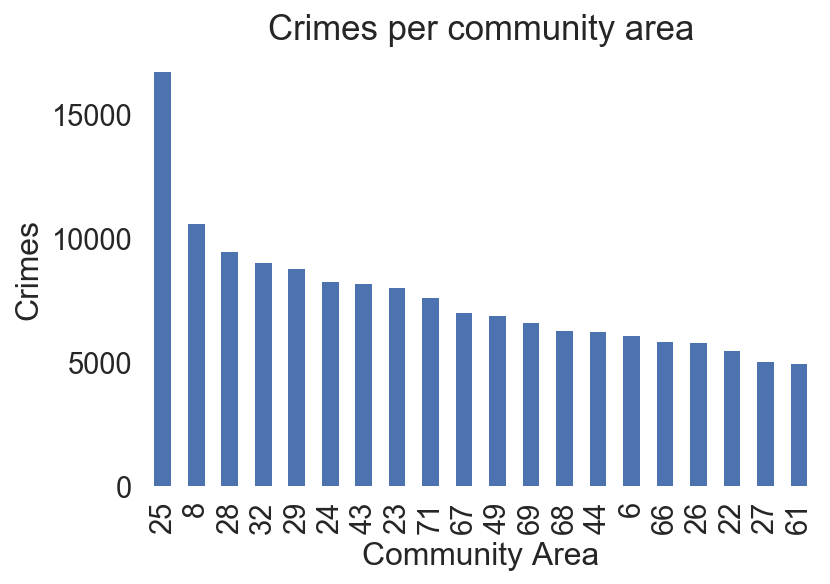

In [294]:
#chi_CA_count.set_index('community_area', inplace = True)
CCA = chi_CA_count.sort_values('id', ascending = False)['id'].head(20).plot.bar()
CCA.set_title("Crimes per community area")
CCA.set_xlabel("Community Area")
CCA.set_ylabel("Crimes")

In [295]:
soql = "https://data.cityofchicago.org/resource/ejsh-fztr.json?$query="
soql += quote("SELECT park_no, acres ")
soql += quote("LIMIT 300000")

resp = requests.get(soql).json()

In [296]:
parkacres = resp

In [346]:
soql = "https://data.cityofchicago.org/resource/eix4-gf83.json?$query="
soql += quote("SELECT park, park_no, the_geom, x_coord, y_coord ")
soql += quote("LIMIT 300000")

resp = requests.get(soql).json()

In [347]:
data = resp
for d in data:
    d['the_geom'] = shape(d['the_geom'])

parkshapes = gpd.GeoDataFrame(data).set_geometry('the_geom')
parkshapes.head()

,park,park_no,the_geom,x_coord,y_coord
0,HAMILTON (ALEXANDER),9,POINT (-87.63769762611605 41.76299921071406),-87.63769763,41.76299921
1,HAMILTON (ALEXANDER),9,POINT (-87.63792902987225 41.76281652333733),-87.63792903,41.76281652
2,HAMILTON (ALEXANDER),9,POINT (-87.63691359952921 41.76084938932824),-87.6369136,41.76084939
3,HAMILTON (ALEXANDER),9,POINT (-87.63832013450852 41.76200535544225),-87.63832013,41.76200536
4,HAMILTON (ALEXANDER),9,POINT (-87.63805916837423 41.7604738451063),-87.63805917,41.76047385


Might be able to use community areas to define polygons, then take the api to only draw parks where the points are within the polygon. Need to parse data from community area polygons and SoQL query.

# New York City

We repeat the process for New York City. NYC had 478804 offenses in 2016, so we place a limit on on SoQL call of 500000

In [386]:
soql = "https://data.cityofnewyork.us/resource/9s4h-37hy.json?$query="
soql += quote("SELECT cmplnt_num,  addr_pct_cd, ofns_desc ")
soql += quote("WHERE date_trunc_y(rpt_dt) = '2016-01-01T00:00:00.000' ")
soql += quote("LIMIT 500000")

resp = requests.get(soql).json()
NYC_crime = pd.DataFrame(resp)
NYC_pre_count = NYC_crime.groupby("addr_pct_cd").count()

In [391]:
NYC_pre_count.reset_index(inplace = True)

In [395]:
NYC_pre_count['addr_pct_cd']

0       1
1      10
2     100
3     101
4     102
5     103
6     104
7     105
8     106
9     107
10    108
11    109
12    110
13    111
14    112
15    113
16    114
17    115
18    120
19    121
20    122
21    123
22     13
23     14
24     17
25     18
26     19
27     20
28     22
29     23
     ... 
47     49
48      5
49     50
50     52
51      6
52     60
53     61
54     62
55     63
56     66
57     67
58     68
59     69
60      7
61     70
62     71
63     72
64     73
65     75
66     76
67     77
68     78
69     79
70     81
71     83
72     84
73     88
74      9
75     90
76     94
Name: addr_pct_cd, Length: 77, dtype: object